# HPT PyTorch Lightning: VBDP {#sec-hyperparameter-tuning-lightning-31}

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch` Lightning
training workflow for a classification task.

This chapter describes the hyperparameter tuning of a `PyTorch Lightning` network on the Vector Borne Disease Prediction (VBDP) data set.

:::{.callout-important}
### Vector Borne Disease Prediction Data Set
This chapter uses the Vector Borne Disease Prediction data set from Kaggle. It is a categorical dataset for eleven Vector Borne Diseases with associated symptoms.

> The person who associated a work with this deed has dedicated the work to the public domain by waiving all of his or her rights to the work worldwide under copyright law, including all related and neighboring rights, to the extent allowed by law.You can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission. See Other Information below, see [https://creativecommons.org/publicdomain/zero/1.0/](https://creativecommons.org/publicdomain/zero/1.0/).

The data set is available at:
[https://www.kaggle.com/datasets/richardbernat/vector-borne-disease-prediction](https://www.kaggle.com/datasets/richardbernat/vector-borne-disease-prediction),

The data should be downloaded and stored in the `data/VBDP` subfolder. The data set is not available as a part of the `spotPython` package.
:::


This document refers to the latest `spotPython` version, which can be installed via pip. Alternatively, the source code can be downloaded from gitHub: [https://github.com/sequential-parameter-optimization/spotPython](https://github.com/sequential-parameter-optimization/spotPython).

* Uncomment the following lines if you want to for (re-)installation the latest version of `spotPython` from GitHub.

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython

## Step 1: Setup {#sec-setup-31}

* Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size, etc. 
* The parameter `MAX_TIME` specifies the maximum run time in seconds.
* The parameter `INIT_SIZE` specifies the initial design size.
* The parameter `WORKERS` specifies the number of workers. 
* The prefix `PREFIX` is used for the experiment name and the name of the log file.


In [2]:
MAX_TIME = 1
INIT_SIZE = 5
WORKERS = 0
PREFIX="030"

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* `MAX_TIME` is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* `INIT_SIZE` is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.
* `WORKERS` is set to 0 for demonstration purposes. For real experiments, this should be increased. See the warnings that are printed when the number of workers is set to 0.

:::

::: {.callout-note}
### Note: Device selection

* Although there are no .cuda() or .to(device) calls required, because Lightning does these for you, see 
[LIGHTNINGMODULE](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html), we would like to know which device is used. Threrefore, we imitate the LightningModule behaviour which selects the highest device. 
* The method `spotPython.utils.device.getDevice()` returns the device that is used by Lightning.
:::


## Step 2: Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process, which was described in @sec-initialization-fun-control-14, see [Initialization of the fun_control Dictionary](https://sequential-parameter-optimization.github.io/spotPython/14_spot_ray_hpt_torch_cifar10.html#sec-initialization-fun-control-14) in the documentation.

In [3]:
from spotPython.utils.init import fun_control_init
from spotPython.utils.file import get_experiment_name, get_spot_tensorboard_path
from spotPython.utils.device import getDevice

experiment_name = get_experiment_name(prefix=PREFIX)
fun_control = fun_control_init(
    spot_tensorboard_path=get_spot_tensorboard_path(experiment_name),
    num_workers=WORKERS,
    device=getDevice(),
    _L_in=64,
    _L_out=11,
    TENSORBOARD_CLEAN=True)

Seed set to 42


In [4]:
fun_control["device"]

'mps'

## Step 3: PyTorch Data Loading {#sec-data-loading-31}

### Lightning Dataset and DataModule

The data loading and preprocessing is handled by `Lightning` and `PyTorch`.
It comprehends the following classes:

*   `CSVDataset`: A class that loads the data from a CSV file. [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/csvdataset.py)
*   `CSVDataModule`: A class that prepares the data for training and testing. [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/csvdatamodule.py)


Section @sec-taking-a-look-at-the-data-31 illustrates how to access the data.



## Loading a local Data set

In [5]:
# PKL
# from spotPython.hyperparameters.values import set_data_module
# from spotPython.data.lightdatamodule import LightDataModule
# from spotPython.data.pkldataset import PKLDataset
# import torch
# dataset = PKLDataset(directory="/Users/bartz/workspace/spotPython/notebooks/data/spotPython/", filename="data_sensitive.pkl", target_column='N', feature_type=torch.float32, target_type=torch.float64, rmNA=False)
# dm = LightDataModule(dataset=dataset, batch_size=5, test_size=77)
# dm.setup()
# set_data_module(fun_control=fun_control,
#                 data_module=dm)

In [6]:
from spotPython.utils.init import fun_control_init
from spotPython.hyperparameters.values import set_data_module, set_data_set
from spotPython.data.lightdatamodule import LightDataModule
from spotPython.data.csvdataset import CSVDataset
import torch
dataset = CSVDataset(directory="/Users/bartz/workspace/spotPython/notebooks/data/VBDP/", filename="train.csv",target_column='prognosis', target_type=torch.long, feature_type=torch.float32, dropId=True)
set_data_set(fun_control=fun_control,
                data_set=dataset)
print(fun_control["data_set"].data.shape)
print(fun_control["data_set"].targets.shape)

torch.Size([707, 64])
torch.Size([707])


In [7]:

# dm = LightDataModule(dataset=dataset, batch_size=5, test_size=0.6)
# dm.setup()
# set_data_module(fun_control=fun_control,
#                 data_module=dm)
# data_module = fun_control["data_module"]
# print(f"Test set size: {len(data_module.data_test)}")




## Step 4: Preprocessing {#sec-preprocessing-31}

Preprocessing is handled by `Lightning` and `PyTorch`. It can be implemented in the `CSVDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/csvdatamodule.py) and is described in the [LIGHTNINGDATAMODULE](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) documentation. Here you can find information about the `transforms` methods.



## Step 5: Select the NN Model (`algorithm`) and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-31}

`spotPython` includes the `NetLightBase` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightbase.py) for configurable neural networks. 
The class is imported here. It inherits from the class `Lightning.LightningModule`, which is the base class for all models in `Lightning`. `Lightning.LightningModule` is a subclass of `torch.nn.Module` and provides additional functionality for the training and testing of neural networks. The class `Lightning.LightningModule` is described in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html).

* Here we simply add the NN Model to the fun_control dictionary by calling the function `add_core_model_to_fun_control`:

In [8]:
from spotPython.light.netlightbase import NetLightBase 
from spotPython.data.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
add_core_model_to_fun_control(core_model=NetLightBase,
                              fun_control=fun_control,
                              hyper_dict= LightHyperDict)

In [9]:
fun_control

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 64,
 '_L_out': 11,
 'data': None,
 'data_dir': './data',
 'data_module': None,
 'data_set': <spotPython.data.csvdataset.CSVDataset at 0x17b4e0690>,
 'device': 'mps',
 'enable_progress_bar': False,
 'eval': None,
 'k_folds': 3,
 'loss_function': None,
 'metric_river': None,
 'metric_sklearn': None,
 'metric_torch': None,
 'metric_params': {},
 'model_dict': {},
 'n_samples': None,
 'num_workers': 0,
 'optimizer': None,
 'path': None,
 'prep_model': None,
 'save_model': False,
 'seed': 1234,
 'show_batch_interval': 1000000,
 'shuffle': None,
 'sigma': 0.0,
 'target_column': None,
 'train': None,
 'test': None,
 'task': 'classification',
 'spot_tensorboard_path': 'runs/spot_logs/030_bartz08-2_2023-11-13_14-11-33',
 'weights': 1.0,
 'spot_writer': <torch.utils.tensorboard.writer.SummaryWriter at 0x10e782890>,
 'core_model': spotPython.light.netlightbase.N

The `NetLightBase` is a configurable neural network. The hyperparameters of the model are specified in the `core_model_hyper_dict` dictionary [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/data/light_hyper_dict.json).

## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-hyperparameters-31}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. These functions were described in @sec-modification-of-hyperparameters-14.

::: {.callout-caution}
### Caution: Small number of epochs for demonstration purposes

* `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[7, 9])` and
  * `modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 7])`
:::

In [10]:
from spotPython.hyperparameters.values import modify_hyper_parameter_bounds

modify_hyper_parameter_bounds(fun_control, "l1", bounds=[5,8])
modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[6,13])
modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[2, 8])

In [11]:
from spotPython.hyperparameters.values import modify_hyper_parameter_levels
modify_hyper_parameter_levels(fun_control, "optimizer",["Adam", "AdamW", "Adamax", "NAdam"])
# modify_hyper_parameter_levels(fun_control, "optimizer", ["Adam"])

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/utils/eda.py) generates a design table as follows:

In [12]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name           | type   | default   |   lower |   upper | transform             |
|----------------|--------|-----------|---------|---------|-----------------------|
| l1             | int    | 3         |     5   |    8    | transform_power_2_int |
| epochs         | int    | 4         |     6   |   13    | transform_power_2_int |
| batch_size     | int    | 4         |     2   |    8    | transform_power_2_int |
| act_fn         | factor | ReLU      |     0   |    5    | None                  |
| optimizer      | factor | SGD       |     0   |    3    | None                  |
| dropout_prob   | float  | 0.01      |     0   |    0.25 | None                  |
| lr_mult        | float  | 1.0       |     0.1 |   10    | None                  |
| patience       | int    | 2         |     2   |    6    | transform_power_2_int |
| initialization | factor | Default   |     0   |    2    | None                  |


This allows to check if all information is available and if the information is correct.

::: {.callout-note}
### Note: Hyperparameters of the Tuned Model and the `fun_control` Dictionary
The updated `fun_control` dictionary can be shown with the command `fun_control["core_model_hyper_dict"]`.
:::


## Step 7: Data Splitting, the Objective (Loss) Function and the Metric

### Evaluation  {#sec-selection-of-target-function-31}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set (see @sec-data-splitting-14)
2. the loss function (and a metric).

::: {.callout-caution}
### Caution: Data Splitting in Lightning

* The data splitting is handled by `Lightning`.

:::

### Loss Functions and Metrics {#sec-loss-functions-and-metrics-31}

The loss function is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightbase.py)
We will use CrossEntropy loss for the multiclass-classification task.

### Metric {#sec-metric-31}

* We will use the MAP@k metric [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/torch/mapk.py) for the evaluation of the model. 
* An example, how this metric works, is shown in the Appendix, see Section {@sec-the-mapk-metric-31}.

Similar to the loss function, the metric is specified in the configurable network class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/netlightbase.py).

::: {.callout-caution}
### Caution: Loss Function and Metric in Lightning

* The loss function and the metric are not hyperparameters that can be tuned with `spotPython`.
* They are handled by `Lightning`.

:::

## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-31}

The following code passes the information about the parameter ranges and bounds to `spot`.
It extracts the variable types, names, and bounds

In [13]:
from spotPython.hyperparameters.values import (get_bound_values,
    get_var_name,
    get_var_type,)
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

### The Objective Function `fun` {#sec-the-objective-function-31}

The objective function `fun` from the class `HyperLight` [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/fun/hyperlight.py) is selected next. It implements an interface from `PyTorch`'s training, validation, and testing methods to `spotPython`.

In [14]:
from spotPython.fun.hyperlight import HyperLight
fun = HyperLight(log_level=50).fun

In [15]:
fun_control

{'CHECKPOINT_PATH': 'runs/saved_models/',
 'DATASET_PATH': 'data/',
 'RESULTS_PATH': 'results/',
 'TENSORBOARD_PATH': 'runs/',
 '_L_in': 64,
 '_L_out': 11,
 'data': None,
 'data_dir': './data',
 'data_module': None,
 'data_set': <spotPython.data.csvdataset.CSVDataset at 0x17b4e0690>,
 'device': 'mps',
 'enable_progress_bar': False,
 'eval': None,
 'k_folds': 3,
 'loss_function': None,
 'metric_river': None,
 'metric_sklearn': None,
 'metric_torch': None,
 'metric_params': {},
 'model_dict': {},
 'n_samples': None,
 'num_workers': 0,
 'optimizer': None,
 'path': None,
 'prep_model': None,
 'save_model': False,
 'seed': 1234,
 'show_batch_interval': 1000000,
 'shuffle': None,
 'sigma': 0.0,
 'target_column': None,
 'train': None,
 'test': None,
 'task': 'classification',
 'spot_tensorboard_path': 'runs/spot_logs/030_bartz08-2_2023-11-13_14-11-33',
 'weights': 1.0,
 'spot_writer': <torch.utils.tensorboard.writer.SummaryWriter at 0x10e782890>,
 'core_model': spotPython.light.netlightbase.N

### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-31}

The `spotPython` hyperparameter tuning is started by calling the `Spot` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/spot/spot.py) as described in @sec-call-the-hyperparameter-tuner-14.

In [16]:
import numpy as np
from spotPython.spot import spot
from math import inf
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   max_time = MAX_TIME,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE},
                   surrogate_control={"noise": True,
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      })
spot_tuner.run()

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have m

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.2865588665008545
         val_acc            0.24852071702480316
        val_loss            2.2865588665008545
       valid_mapk           0.3180941343307495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 23.2 K
------------------------------------------
23.2 K    Trainable params
0         Non-trainable params
23.2 K    Total params
0.093     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.34614896774292
         val_acc            0.15976330637931824
        val_loss             2.34614896774292
       valid_mapk           0.21794871985912323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 8.0 K 
------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.412863254547119
         val_acc            0.13017751276493073
        val_loss             2.412863254547119
       valid_mapk           0.2026515007019043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 8.0 K 
------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.4111385345458984
         val_acc            0.05917159840464592
        val_loss            2.4111385345458984
       valid_mapk           0.12394781410694122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.397771120071411
         val_acc            0.08875739574432373
        val_loss             2.397771120071411
       valid_mapk           0.1812119036912918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.399320363998413
         val_acc            0.13609467446804047
        val_loss             2.399320363998413
       valid_mapk           0.22386187314987183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#---------] 8.18% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 8.0 K 
------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.3316354751586914
         val_acc            0.20118343830108643
        val_loss            2.3316354751586914
       valid_mapk           0.2926136255264282
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [####------] 41.70% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.10059171915054321
        val_loss                    nan
       valid_mapk           0.17891590297222137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#####-----] 47.23% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.11834319680929184
        val_loss                    nan
       valid_mapk           0.15943287312984467
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#####-----] 50.55% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.12426035851240158
        val_loss                    nan
       valid_mapk           0.1957947462797165
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#####-----] 53.54% 
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.09467455744743347
        val_loss                    nan
       valid_mapk           0.16087962687015533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [######----] 55.50% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.0710059180855751
        val_loss                    nan
       valid_mapk           0.15489967167377472
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [######----] 58.10% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.10650887340307236
        val_loss                    nan
       valid_mapk           0.1818094104528427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [######----] 60.52% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.08875739574432373
        val_loss                    nan
       valid_mapk           0.1679205298423767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [######----] 63.61% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.13017751276493073
        val_loss                    nan
       valid_mapk           0.21730323135852814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#######---] 67.13% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.0710059180855751
        val_loss                    nan
       valid_mapk           0.15133102238178253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#######---] 69.09% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.09467455744743347
        val_loss                    nan
       valid_mapk           0.20023147761821747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#######---] 72.29% 
fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.09467455744743347
        val_loss                    nan
       valid_mapk           0.15287423133850098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#######---] 74.91% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.08284023404121399
        val_loss                    nan
       valid_mapk           0.1636766940355301
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [########--] 77.05% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.07692307978868484
        val_loss                    nan
       valid_mapk           0.15200616419315338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [########--] 79.41% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.0710059180855751
        val_loss                    nan
       valid_mapk           0.14438657462596893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [########--] 82.01% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.08875739574432373
        val_loss                    nan
       valid_mapk           0.15557484328746796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [########--] 84.29% 
fun: Calling train_model


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.1124260351061821
        val_loss                    nan
       valid_mapk           0.17679399251937866
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#########-] 86.17% 
fun: Calling train_model


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.10059171915054321
        val_loss                    nan
       valid_mapk           0.18566744029521942
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#########-] 88.60% 
fun: Calling train_model


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.06508875638246536
        val_loss                    nan
       valid_mapk           0.13898533582687378
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [#########-] 92.82% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-pack

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.10650887340307236
        val_loss                    nan
       valid_mapk           0.22945602238178253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [##########] 96.07% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.08875739574432373
        val_loss                    nan
       valid_mapk           0.1679205298423767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [##########] 98.86% 


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:634: Checkpoint directory runs/lightning_logs/-2535008608599031625/checkpoints exists and is not empty.

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total 

fun: Calling train_model
torch.Size([707, 64])
torch.Size([707])
train_model(): Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric                   nan
         val_acc            0.08284023404121399
        val_loss                    nan
       valid_mapk           0.16049382090568542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
fun: train_model returned
spotPython tuning: 2.2865588665008545 [##########] 100.00% Done...



## Step 9: Tensorboard {#sec-tensorboard-31}

The textual output shown in the console (or code cell) can be visualized with Tensorboard.

```{raw}
tensorboard --logdir="runs/"
```

Further information can be found in the [PyTorch Lightning documentation](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.tensorboard.html) for Tensorboard.

## Step 10: Results {#sec-results-31}

After the hyperparameter tuning run is finished, the results can be analyzed as described in @sec-results-14.

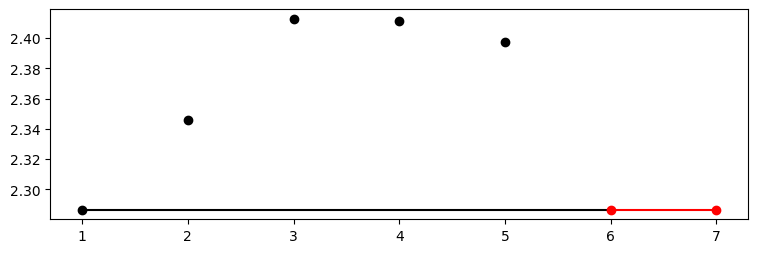

In [17]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False,
    filename="./figures/" + experiment_name+"_progress.png")

In [18]:
#| fig-cap: Results of the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name           | type   | default   |   lower |   upper |               tuned | transform             |   importance | stars   |
|----------------|--------|-----------|---------|---------|---------------------|-----------------------|--------------|---------|
| l1             | int    | 3         |     5.0 |     8.0 |                 8.0 | transform_power_2_int |         0.00 |         |
| epochs         | int    | 4         |     6.0 |    13.0 |                12.0 | transform_power_2_int |         0.00 |         |
| batch_size     | int    | 4         |     2.0 |     8.0 |                 5.0 | transform_power_2_int |         0.27 | .       |
| act_fn         | factor | ReLU      |     0.0 |     5.0 |                 2.0 | None                  |       100.00 | ***     |
| optimizer      | factor | SGD       |     0.0 |     3.0 |                 1.0 | None                  |         0.00 |         |
| dropout_prob   | float  | 0.01      |     0.0 |    0.25 | 0.10939527466721133 | N

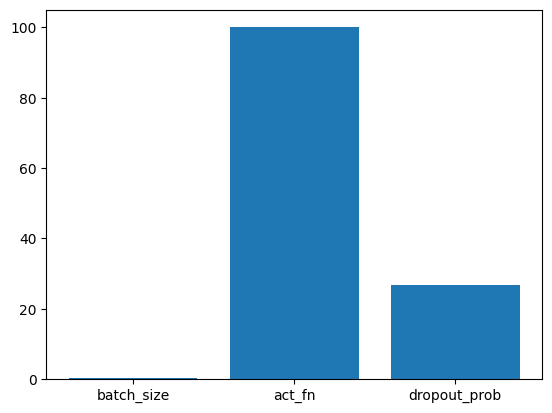

In [19]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=0.025,
    filename="./figures/" + experiment_name+"_importance.png")

### Get the Tuned Architecture {#sec-get-spot-results-31}

In [20]:
from spotPython.light.utils import get_tuned_architecture
config = get_tuned_architecture(spot_tuner, fun_control)

* Test on the full data set

In [21]:
from spotPython.light.traintest import test_model
test_model(config, fun_control)

/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)



******
In test_model: torch.Size([707, 64])
torch.Size([707])
Test set size: 425


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Restoring states from the checkpoint path at /Users/bart

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.234036684036255
     test_mapk_epoch        0.3994295597076416
         val_acc            0.30352941155433655
        val_loss             2.234036684036255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


(2.234036684036255, 0.30352941155433655)

In [22]:
from spotPython.light.traintest import load_light_from_checkpoint

model_loaded = load_light_from_checkpoint(config, fun_control)

Loading model from runs/saved_models/3624294384592252179_TEST/last.ckpt


### Cross Validation With Lightning

* The `KFold` class from `sklearn.model_selection` is used to generate the folds for cross-validation.
* These mechanism is used to generate the folds for the final evaluation of the model.
* The `CrossValidationDataModule` class [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/crossvalidationdatamodule.py) is used to generate the folds for the hyperparameter tuning process.
* It is called from the `cv_model` function [[SOURCE]](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotPython/light/traintest.py).

In [23]:
from spotPython.light.traintest import cv_model
# set the number of folds to 10
fun_control["k_folds"] = 10
cv_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | train_mapk | MAPK       | 0     
1 | valid_mapk | MAPK       | 0     
2 | test_mapk  | MAPK       | 0     
3 | layers     | Sequential | 75.0 K
------------------------------------------
75.0 K    Trainable params
0         Non-trainable params
75.0 K    Total params
0.300     Total estimated model params size (MB)


k: 0
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.303966999053955
         val_acc            0.23943662643432617
        val_loss             2.303966999053955
       valid_mapk           0.3477182388305664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.3477182388305664, 'val_loss': 2.303966999053955, 'val_acc': 0.23943662643432617, 'hp_metric': 2.303966999053955}
k: 1
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.244103193283081
         val_acc            0.30985915660858154
        val_loss             2.244103193283081
       valid_mapk           0.3638392984867096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.3638392984867096, 'val_loss': 2.244103193283081, 'val_acc': 0.30985915660858154, 'hp_metric': 2.244103193283081}
k: 2
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.343712091445923
         val_acc            0.18309858441352844
        val_loss             2.343712091445923
       valid_mapk           0.2113095372915268
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.2113095372915268, 'val_loss': 2.343712091445923, 'val_acc': 0.18309858441352844, 'hp_metric': 2.343712091445923}
k: 3
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.310716152191162
         val_acc            0.22535210847854614
        val_loss             2.310716152191162
       valid_mapk           0.3191964328289032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.3191964328289032, 'val_loss': 2.310716152191162, 'val_acc': 0.22535210847854614, 'hp_metric': 2.310716152191162}
k: 4
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.3211772441864014
         val_acc            0.22535210847854614
        val_loss            2.3211772441864014
       valid_mapk           0.3038194477558136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.3038194477558136, 'val_loss': 2.3211772441864014, 'val_acc': 0.22535210847854614, 'hp_metric': 2.3211772441864014}
k: 5
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.2300426959991455
         val_acc            0.30985915660858154
        val_loss            2.2300426959991455
       valid_mapk                0.421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.421875, 'val_loss': 2.2300426959991455, 'val_acc': 0.30985915660858154, 'hp_metric': 2.2300426959991455}
k: 6
Train Dataset Size: 636
Val Dataset Size: 71


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.3636953830718994
         val_acc            0.18309858441352844
        val_loss            2.3636953830718994
       valid_mapk           0.2708333432674408
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.2708333432674408, 'val_loss': 2.3636953830718994, 'val_acc': 0.18309858441352844, 'hp_metric': 2.3636953830718994}
k: 7
Train Dataset Size: 637
Val Dataset Size: 70


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.2502951622009277
         val_acc            0.2857142984867096
        val_loss            2.2502951622009277
       valid_mapk           0.4357639253139496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.4357639253139496, 'val_loss': 2.2502951622009277, 'val_acc': 0.2857142984867096, 'hp_metric': 2.2502951622009277}
k: 8
Train Dataset Size: 637
Val Dataset Size: 70


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric           2.3760530948638916
         val_acc            0.15714286267757416
        val_loss            2.3760530948638916
       valid_mapk           0.3229166567325592
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.3229166567325592, 'val_loss': 2.3760530948638916, 'val_acc': 0.15714286267757416, 'hp_metric': 2.3760530948638916}
k: 9
Train Dataset Size: 637
Val Dataset Size: 70


/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        hp_metric            2.25710129737854
         val_acc            0.2857142984867096
        val_loss             2.25710129737854
       valid_mapk           0.3431713283061981
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
train_model result: {'valid_mapk': 0.3431713283061981, 'val_loss': 2.25710129737854, 'val_acc': 0.2857142984867096, 'hp_metric': 2.25710129737854}


0.3340443208813667

::: {.callout-note}
### Note: Evaluation for the Final Comaprison

* This is the evaluation that will be used in the comparison.

:::


### Detailed Hyperparameter Plots

batch_size:  0.26660351836730645
act_fn:  100.0
dropout_prob:  26.865059698559463


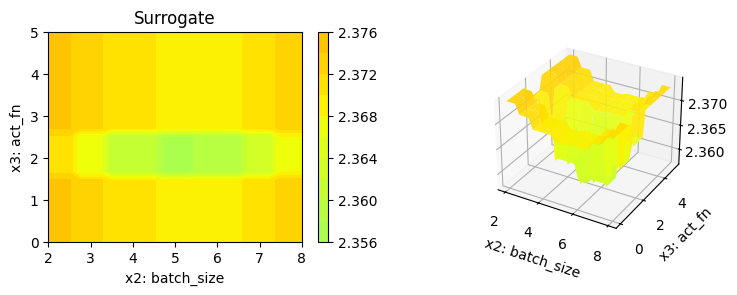

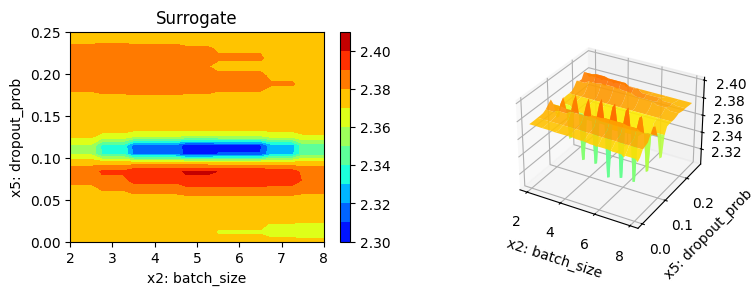

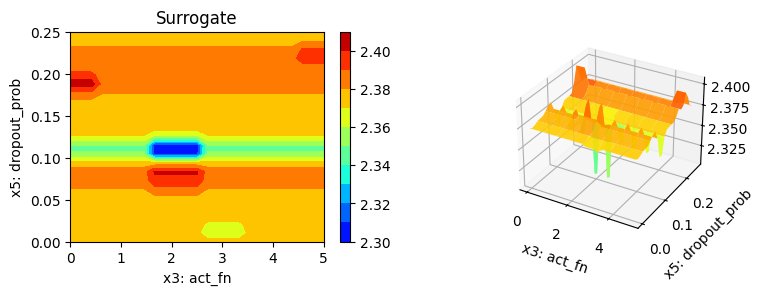

In [24]:
#| fig-cap: Contour plots.
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

### Parallel Coordinates Plot

In [25]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [26]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)

### Visualizing the Activation Distribution

::: {.callout-note}
### Reference:

* The following code is based on [[PyTorch Lightning TUTORIAL 2: ACTIVATION FUNCTIONS]](https://lightning.ai/docs/pytorch/stable/notebooks/course_UvA-DL/02-activation-functions.html), Author: Phillip Lippe, License: [[CC BY-SA]](https://creativecommons.org/licenses/by-sa/3.0/), Generated: 2023-03-15T09:52:39.179933.

:::

After we have trained the models, we can look at the actual activation values that find inside the model. For instance, how many neurons are set to zero in ReLU? Where do we find most values in Tanh? To answer these questions, we can write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activations inside the network:

In [27]:
from spotPython.torch.activation import Sigmoid, Tanh, ReLU, LeakyReLU, ELU, Swish
act_fn_by_name = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": ReLU, "leakyrelu": LeakyReLU, "elu": ELU, "swish": Swish}

In [28]:
from spotPython.hyperparameters.values import get_one_config_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
config = get_one_config_from_X(X, fun_control)
model = fun_control["core_model"](**config, _L_in=64, _L_out=11)
model

/Users/bartz/miniforge3/envs/py311/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: UserWarning:

Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.



NetLightBase(
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.10939527466721133, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.10939527466721133, inplace=False)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.10939527466721133, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.10939527466721133, inplace=False)
    (12): Linear(in_features=64, out_features=11, bias=True)
  )
)

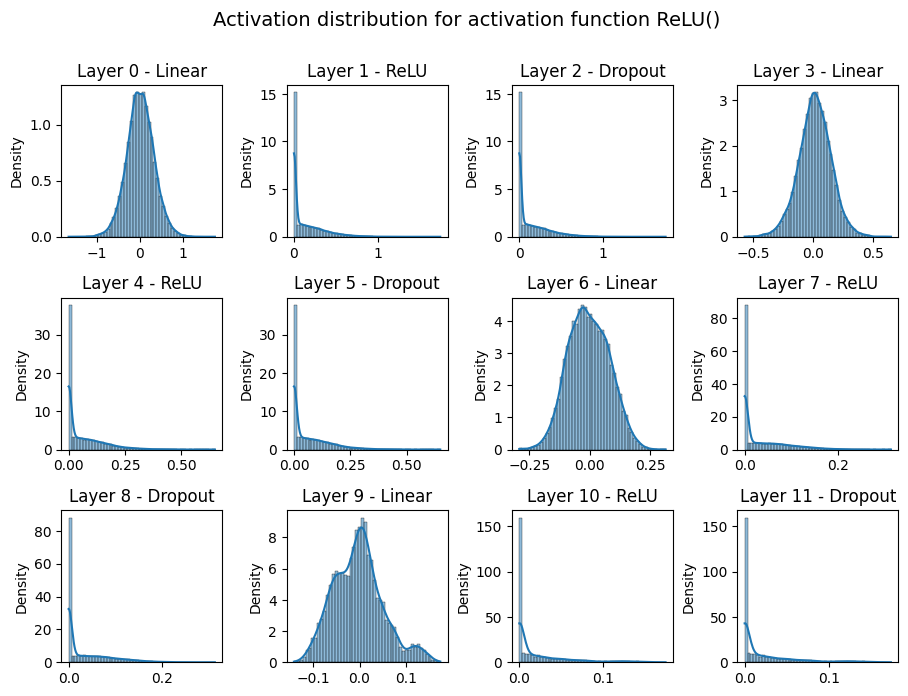

In [29]:
from spotPython.utils.eda import visualize_activations
visualize_activations(model, color=f"C{0}")

## Submission

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

In [31]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
train_df = pd.read_csv('./data/VBDP/train.csv', index_col=0)
# remove the id column
# train_df = train_df.drop(columns=['id'])
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# Encode our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
y = enc.fit_transform(train_df[[target_column]])
test_df = pd.read_csv('./data/VBDP/test.csv', index_col=0)
test_df

,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,hypotension,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
id,,,,,,,,,,,,,,,,,,,,,
707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [32]:
import torch
X_tensor = torch.Tensor(test_df.values)
X_tensor = X_tensor.to(fun_control["device"])

In [33]:
y = model_loaded(X_tensor)
y.shape

torch.Size([303, 11])

In [34]:
# convert the predictions to a numpy array
y = y.cpu().detach().numpy()
y

array([[1.50741957e-32, 1.85128840e-32, 1.00000000e+00, ...,
        2.14590733e-20, 1.60721969e-31, 5.23741600e-34],
       [8.41047615e-02, 9.11747515e-01, 2.94991809e-11, ...,
        6.06451389e-10, 9.09396891e-10, 3.32624163e-15],
       [1.15861283e-16, 1.82524520e-08, 1.33733366e-07, ...,
        7.93107390e-01, 2.06880987e-01, 1.44676700e-14],
       ...,
       [1.40033141e-16, 8.06990840e-07, 1.04850295e-10, ...,
        1.65781366e-05, 9.92298901e-01, 2.36591915e-13],
       [1.05749833e-10, 3.65543638e-05, 7.40824044e-06, ...,
        1.47678971e-03, 5.08246303e-01, 1.49546615e-08],
       [8.34339841e-24, 2.11603948e-22, 1.00000000e+00, ...,
        1.75468059e-14, 1.31957189e-19, 7.84660631e-23]], dtype=float32)

In [35]:
test_sorted_prediction_ids = np.argsort(-y, axis=1)
test_top_3_prediction_ids = test_sorted_prediction_ids[:,:3]
original_shape = test_top_3_prediction_ids.shape
test_top_3_prediction = enc.inverse_transform(test_top_3_prediction_ids.reshape(-1, 1))
test_top_3_prediction = test_top_3_prediction.reshape(original_shape)
test_df['prognosis'] = np.apply_along_axis(lambda x: np.array(' '.join(x), dtype="object"), 1, test_top_3_prediction)
test_df['prognosis'].reset_index().to_csv('./data/VBDP/submission.csv', index=False)

## Appendix

### Differences to the spotPython Approaches for `torch`, `sklearn` and `river`

::: {.callout-caution}
#### Caution: Data Loading in Lightning

* Data loading is handled independently from the `fun_control` dictionary by `Lightning` and `PyTorch`.
* In contrast to `spotPython` with `torch`, `river` and `sklearn`, the data sets are not added to the `fun_control` dictionary.
:::

#### Specification of the Preprocessing Model {#sec-specification-of-preprocessing-model-31}

The `fun_control` dictionary, the `torch`, `sklearn`and `river` versions of `spotPython` allow the specification of a data preprocessing pipeline, e.g., for the scaling of the data or for the one-hot encoding of categorical variables, see @sec-specification-of-preprocessing-model-14. This feature is not used in the `Lightning` version.

:::{.callout-caution}
#### Caution: Data preprocessing in Lightning

Lightning allows the data preprocessing to be specified in the `LightningDataModule` class. It is not considered here, because it should be computed at one location only.
:::

### Taking a Look at the Data {#sec-taking-a-look-at-the-data-31}

In [36]:
import torch
from spotPython.light.vbdpdataset import CSVDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Create an instance of CSVDataset
dataset = CSVDataset(csv_file="./data/VBDP/train.csv", train=True)
# show the dimensions of the input data
print(dataset[0][0].shape)
# show the first element of the input data
print(dataset[0][0])
# show the size of the dataset
print(f"Dataset Size: {len(dataset)}")

torch.Size([64])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Dataset Size: 707


In [37]:
# Set batch size for DataLoader
batch_size = 3
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

Batch Size: 3
---------------
Inputs: tensor([[0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
         0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
         0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Targets: tensor([0, 8, 6])


### The MAPK Metric {#sec-the-mapk-metric-31}

Here is an example how the MAPK metric is calculated.

In [38]:
from spotPython.torch.mapk import MAPK
import torch
mapk = MAPK(k=2)
target = torch.tensor([0, 1, 2, 2])
preds = torch.tensor(
    [
        [0.5, 0.2, 0.2],  # 0 is in top 2
        [0.3, 0.4, 0.2],  # 1 is in top 2
        [0.2, 0.4, 0.3],  # 2 is in top 2
        [0.7, 0.2, 0.1],  # 2 isn't in top 2
    ]
)
mapk.update(preds, target)
print(mapk.compute()) # tensor(0.6250)

tensor(0.6250)
